# Detector systematics

#### Exercise
* Use trmodel to generate response matrices for
    * Deadlayer and backscattering
    * Fano noise
    * Charge sharing
    * Electronic noise

* Convolve / multiply the matrices with input spectra and plot the output
    * Input: Rough range of monoenergetic input spectra
    * Input: Binned differential tritium spectrum
    * Use a log scale in y where it helps
* Combine all matrices into one response and convolve first with a monoenergetic and then with the tritium spectrum
* Show the impact of systematics on the sterile neutrino signature by plotting the specturm with systematics for several sterile mixing angles and a mass of 10keV

In [6]:
import numpy as np
import plotInterface as pi; pi.init()
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from spectrum import *
import trmodel.pkg_detector.model_detector as det
from trmodel.lib.binning import binning

angleBins = binning(0,1,25)

## Define input spectra 

In [16]:
# Binning (rather don't change binning)
nBins       = 400
eBinEdges   = np.linspace(0,40000,nBins+1)
eBinCenters = (eBinEdges[:-1]+eBinEdges[1:])/2

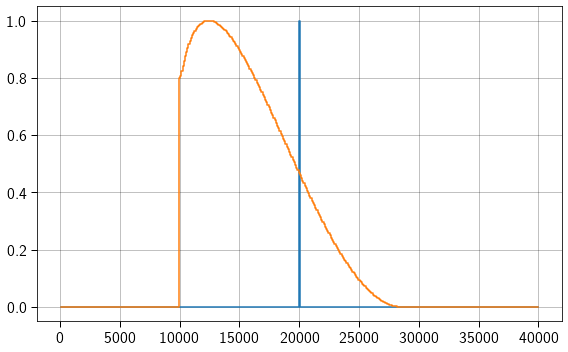

In [30]:
# Monoenergetic spectrum can be constructed like this
specMono = np.zeros(400)
specMono[200] = 1

# Get binned tritium spectrum from function in separate file and normalize
Epae = 10000 # Energy is shifted by 10keV due to post acceleration electrode
specTrit = diffspec_mixed_binned(eBinEdges-Epae)
specTrit = specTrit/specTrit.sum()

# Plot
plt.step(eBinCenters, specMono)
plt.step(eBinCenters, specTrit/specTrit.max())
pi.plotty()

## Deadlayer (quantum efficiency) and backscattering

gen_binning_w binning(nbin=11, vmin=9.5, vmax=20.5)
initialize detector model with (25, 400, 400) bins


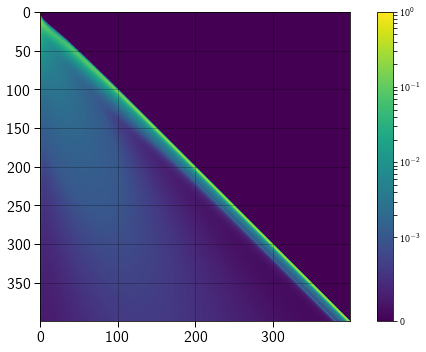

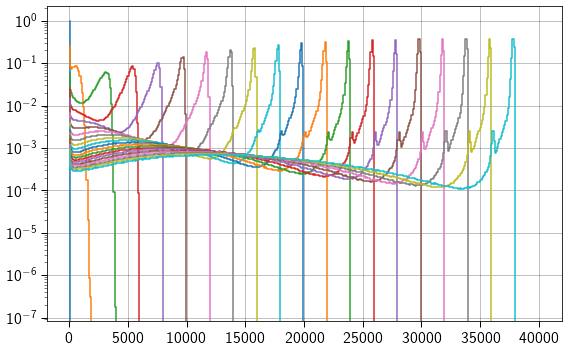

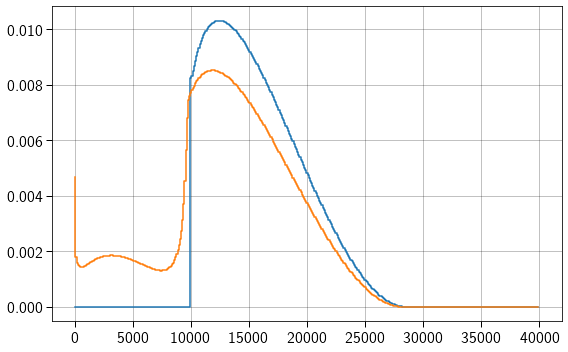

In [57]:
# Initialize detector model
det.init(angleBins,mcdet_ftype='npy',mcdet_NEbin=400,cs_implementation='1D',
        qe_backscattering = True,
        charge_sharing    = False,
        fano_noise        = False)

# Get response matrix
# Note: Response matrix has usually two components:
#       - 3D: Response for deadlayer and backscattering depends on input energy and angle -> maps 2D to 1D and therefore matrix is 3D
#       - 2D: Response for charge sharing and fano noise depends only on energy -> maps 1D to 1D therefore matrix is 2D
resp2D,resp3D = det.get_response_matrix(det_lambda=55)
resp = resp3D[-1] # here we take only the component of the 3D matrix which corresponds to 0° incidence angle
resp1 = resp.copy() # save for later

# Plot of the response matrix
plt.imshow(resp, norm=colors.SymLogNorm(1e-3,base=10))
plt.colorbar()
pi.plotty()

# Generate Monoenergetic spectra, convolve and plot
for i in range(0,nBins,int(nBins/20)):
    specMono = np.zeros(nBins)
    specMono[i] = 1

    convMono = np.dot(resp.T,specMono)
    plt.step(eBinCenters, convMono)
pi.plotty(log='y')

# Convolution for tritium spectrum
convTrit = np.dot(resp.T,specTrit)

plt.step(eBinCenters, specTrit)
plt.step(eBinCenters, convTrit)
pi.plotty()

## Fano noise

gen_binning_w binning(nbin=11, vmin=9.5, vmax=20.5)
initialize detector model with (400, 400) bins


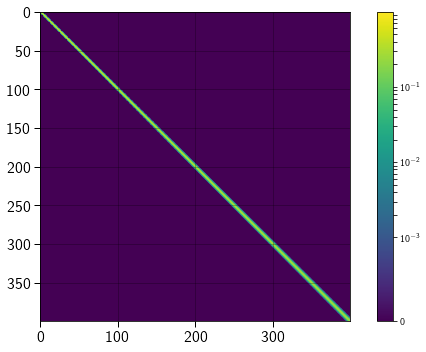

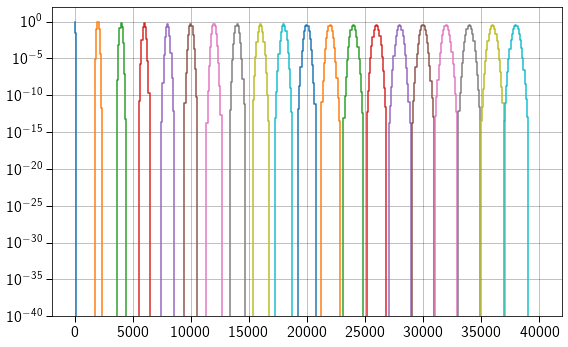

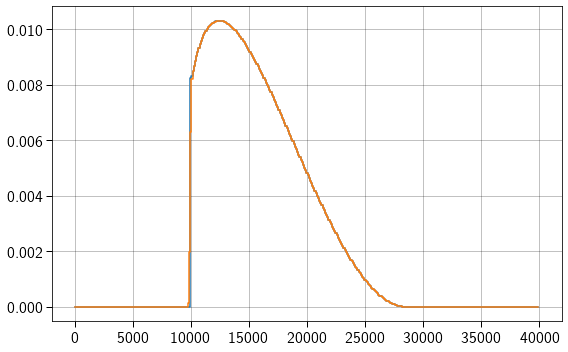

In [58]:
# Initialize detector model
det.init(angleBins,mcdet_ftype='npy',mcdet_NEbin=400,cs_implementation='1D',
        qe_backscattering = False,
        charge_sharing    = False,
        fano_noise        = True)

# Get response matrix
resp2D,resp3D = det.get_response_matrix()
resp = resp2D # now we take the 2D, since here we have the fano noise
resp2 = resp.copy() # save for later

# plot response matrix
plt.imshow(resp, norm=colors.SymLogNorm(1e-3,base=10))
plt.colorbar()
pi.plotty()

for i in range(0,nBins,int(nBins/20)):
    specMono = np.zeros(nBins)
    specMono[i] = 1

    convMono = np.dot(resp.T,specMono)
    plt.step(eBinCenters, convMono)
pi.plotty(log='y', ylim=[1e-40,100])

convTrit = np.dot(resp.T, specTrit)
plt.step(eBinCenters, specTrit)
plt.step(eBinCenters, convTrit)
pi.plotty()

## Charge sharing

gen_binning_w binning(nbin=11, vmin=9.5, vmax=20.5)
initialize detector model with (400, 400) bins


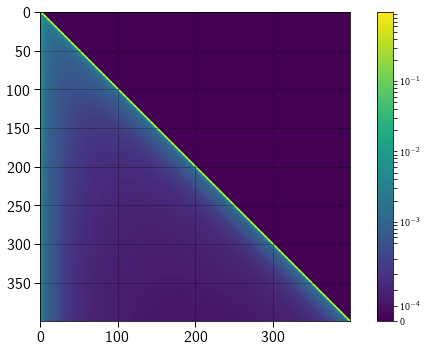

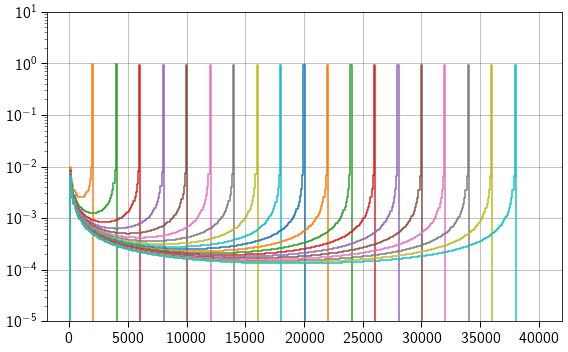

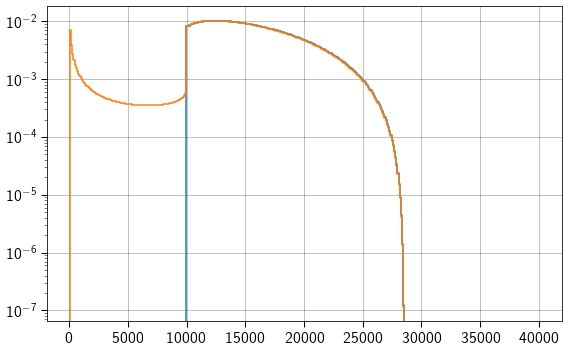

In [62]:
# Initialize detector model
det.init(angleBins,mcdet_ftype='npy',mcdet_NEbin=400,cs_implementation='1D',
        qe_backscattering = False,
        charge_sharing    = True,
        fano_noise        = False)

# Get response matrix
resp2D,resp3D = det.get_response_matrix(det_ccWidth=15,det_pxRadius=1500.)
resp = resp2D # charge sharing is also part of the 2D response
resp3 = resp.copy() # save for later

# plot response matrix
plt.imshow(resp, norm=colors.SymLogNorm(5e-4,base=10))
plt.colorbar()
pi.plotty()

for i in range(0,nBins,int(nBins/20)):
    specMono = np.zeros(nBins)
    specMono[i] = 1

    convMono = np.dot(resp.T,specMono)
    plt.step(eBinCenters, convMono)
pi.plotty(log='y', ylim=[1e-5,10])

convTrit = np.dot(resp.T,specTrit)
plt.step(eBinCenters, specTrit)
plt.step(eBinCenters, convTrit)
pi.plotty(log='y')

## All combined

In [60]:
# Get all response matrices

# (retrieve from above)

#--------------------------------------------------------------------
# combine all matrices into one

# First: Construct identity matrix
respTotal = np.zeros((nBins,nBins))
np.fill_diagonal(respTotal, 1)

# Multiply it all together
for resp in [resp1,resp2,resp3]:
    respTotal = np.matmul(respTotal, resp)

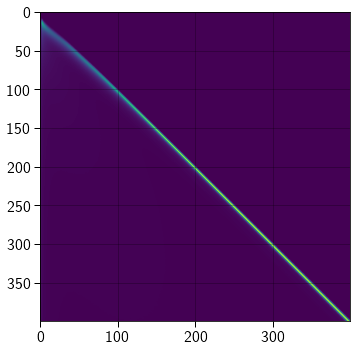

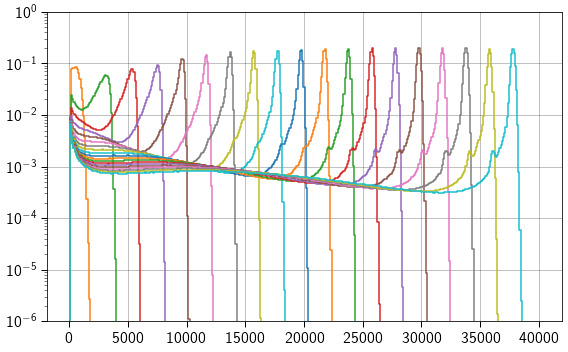

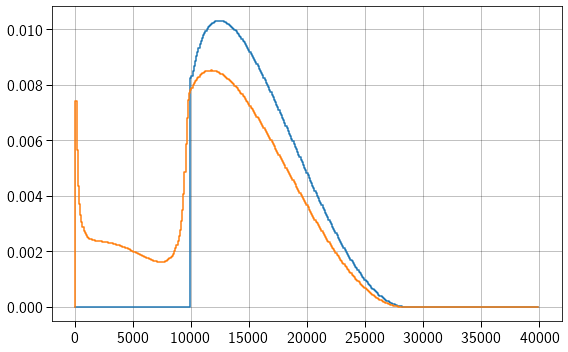

In [63]:
plt.imshow(respTotal)
pi.plotty()

for i in range(0,nBins,int(nBins/20)):
    specMono = np.zeros(nBins)
    specMono[i] = 1

    convMono = np.dot(respTotal.T,specMono)
    plt.step(eBinCenters, convMono)
pi.plotty(log='y', ylim=[1e-6,1])

convTrit = np.dot(respTotal.T,specTrit)
plt.step(eBinCenters, specTrit)
plt.step(eBinCenters, convTrit)
pi.plotty()

## Impact on sterile signature

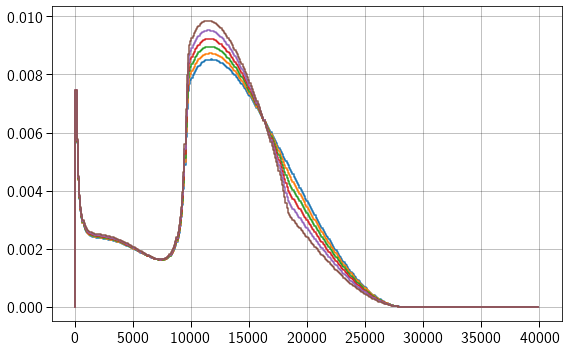

In [64]:
for s2t in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    spec = diffspec_mixed_binned(eBinEdges-Epae,10000,s2t)
    spec = spec/spec.sum()
    
    conv = np.dot(respTotal.T,spec)
    plt.step(eBinCenters, conv)
    
pi.plotty()